In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import random
from collections import deque

# Reproducibility setup
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_HEIGHT, IMG_WIDTH = 256, 512
BATCH_SIZE = 512
EPOCHS = 200
LEARNING_RATE = 0.0001
WARNING_THRESHOLD = 0.15  # 15% of image width
RESET_THRESHOLD = 0.08   # Hysteresis threshold
HYSTERESIS_FRAMES = 5    # Frames to reset warning

print(f"Using device: {DEVICE}")
print(f"Image resolution: {IMG_HEIGHT}x{IMG_WIDTH}")

Using device: cuda
Image resolution: 256x512


Generating synthetic dataset...
Dataset created: 100 training, 20 test samples


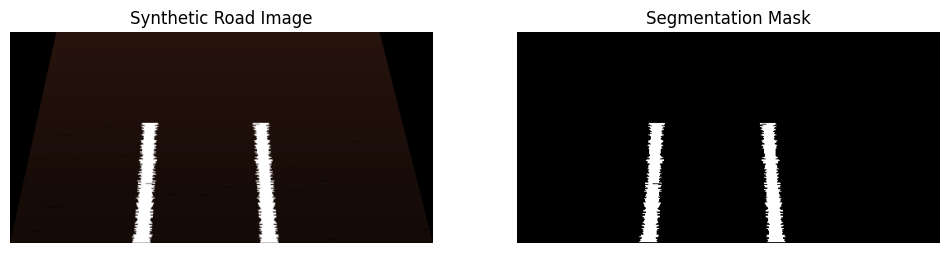

In [29]:
def generate_synthetic_lane_image():
    """Generate a synthetic road image with lane markings"""
    img = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)

    # Road surface with gradient
    road = np.linspace(40, 20, IMG_HEIGHT).astype(np.uint8)
    for i in range(IMG_HEIGHT):
        img[i, :] = [road[i], road[i]//2, road[i]//3]

    # Generate random lane polynomials (y = Ay² + By + C)
    A_left = np.random.uniform(-0.00005, -0.00001)
    B_left = np.random.uniform(0.005, 0.015)
    C_left = np.random.uniform(100, 180)

    A_right = np.random.uniform(0.00001, 0.00005)
    B_right = np.random.uniform(-0.015, -0.005)
    C_right = np.random.uniform(300, 400)

    # Draw left lane
    y_points = np.arange(IMG_HEIGHT - 1, IMG_HEIGHT//2 - 1, -1)
    x_left = A_left * y_points**2 + B_left * y_points + C_left
    x_left = np.clip(x_left, 0, IMG_WIDTH-1).astype(int)

    # Draw right lane
    x_right = A_right * y_points**2 + B_right * y_points + C_right
    x_right = np.clip(x_right, 0, IMG_WIDTH-1).astype(int)

    # Add lane markings with noise
    for i, y in enumerate(y_points):
        # Left lane
        lane_width = np.random.randint(15, 25)
        x = x_left[i]
        img[y, max(0, x-lane_width//2):min(IMG_WIDTH, x+lane_width//2)] = [255, 255, 255]

        # Right lane
        x = x_right[i]
        img[y, max(0, x-lane_width//2):min(IMG_WIDTH, x+lane_width//2)] = [255, 255, 255]

        # Add noise (simulating dirt/shadow)
        if np.random.rand() > 0.8:
            shadow_width = np.random.randint(5, 15)
            shadow_start = np.random.randint(0, IMG_WIDTH - shadow_width)
            img[y, shadow_start:shadow_start+shadow_width] = img[y, shadow_start:shadow_start+shadow_width] // 2

    # Add perspective effect
    pts1 = np.float32([[0, 0], [IMG_WIDTH, 0], [0, IMG_HEIGHT], [IMG_WIDTH, IMG_HEIGHT]])
    pts2 = np.float32([
        [np.random.randint(50, 100), 0],
        [np.random.randint(IMG_WIDTH-100, IMG_WIDTH-50), 0],
        [0, IMG_HEIGHT],
        [IMG_WIDTH, IMG_HEIGHT]
    ])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    img = cv2.warpPerspective(img, M, (IMG_WIDTH, IMG_HEIGHT))

    return img

def create_segmentation_mask(image):
    """Create binary mask for lane pixels (white = lane)"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 200, 1, cv2.THRESH_BINARY)
    return mask.astype(np.float32)

# Generate dataset
def generate_dataset(num_samples):
    images = []
    masks = []
    for _ in range(num_samples):
        img = generate_synthetic_lane_image()
        mask = create_segmentation_mask(img)
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

print("Generating synthetic dataset...")
train_images, train_masks = generate_dataset(100)
test_images, test_masks = generate_dataset(20)

print(f"Dataset created: {len(train_images)} training, {len(test_images)} test samples")

# Visualize sample
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(train_images[0])
plt.title("Synthetic Road Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(train_masks[0], cmap='gray')
plt.title("Segmentation Mask")
plt.axis('off')
plt.show()

In [30]:
class DepthwiseSeparableConv(nn.Module):
    """Optimized convolution block for mobile deployment"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size, stride, padding,
            groups=in_channels, bias=False
        )
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, bias=False
        )
        self.relu = nn.ReLU6()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return self.relu(x)

class LaneNet(nn.Module):
    """Ultra-lightweight lane detection network with correct output dimensions"""
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = DepthwiseSeparableConv(3, 16, kernel_size=3, stride=1, padding=1)     # 256x512
        self.enc2 = DepthwiseSeparableConv(16, 32, kernel_size=3, stride=2, padding=1)    # 128x256
        self.enc3 = DepthwiseSeparableConv(32, 64, kernel_size=3, stride=2, padding=1)    # 64x128
        self.enc4 = DepthwiseSeparableConv(64, 128, kernel_size=3, stride=2, padding=1)   # 32x64

        # Bottleneck
        self.bottleneck = nn.Sequential(
            DepthwiseSeparableConv(128, 256, kernel_size=3, padding=1),
            nn.Dropout2d(0.2),
            DepthwiseSeparableConv(256, 128, kernel_size=3, padding=1)
        )

        # Decoder with explicit output sizing
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 32x64 -> 64x128
            nn.ReLU6()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=2, stride=2),  # 64x128 -> 128x256
            nn.ReLU6()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, kernel_size=2, stride=2),   # 128x256 -> 256x512
            nn.ReLU6()
        )
        # No dec4 - we already reach target resolution after dec3

        # Final conv to get single-channel output
        self.final = nn.Conv2d(16, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)        # 256x512
        e2 = self.enc2(e1)       # 128x256
        e3 = self.enc3(e2)       # 64x128
        e4 = self.enc4(e3)       # 32x64

        # Bottleneck
        b = self.bottleneck(e4)  # 32x64

        # Decoder with skip connections
        d1 = self.dec1(b)
        d1 = torch.cat([d1, e3], dim=1)

        d2 = self.dec2(d1)
        d2 = torch.cat([d2, e2], dim=1)

        d3 = self.dec3(d2)

        out = self.final(d3)
        return self.sigmoid(out)

# Initialize model
model = LaneNet().to(DEVICE)
print(f"Model initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters")

# Test forward pass
test_input = torch.randn(1, 3, IMG_HEIGHT, IMG_WIDTH).to(DEVICE)
with torch.no_grad():
    start = time.time()
    output = model(test_input)
    latency = (time.time() - start) * 1000
print(f"Forward pass latency: {latency:.2f} ms (expected < 45ms for 22+ FPS)")

Model initialized with 134,204 parameters
Forward pass latency: 1.49 ms (expected < 45ms for 22+ FPS)


Starting training...
Epoch 1/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.32s
Epoch 2/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.45s
Epoch 3/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.43s
Epoch 4/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.46s
Epoch 5/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.46s
Epoch 6/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.51s
Epoch 7/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.68s
Epoch 8/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.47s
Epoch 9/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.45s
Epoch 10/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.60s
Epoch 11/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.26s
Epoch 12/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.25s
Epoch 13/200 | Train Loss: 0.9321 | Val Loss: 0.9316 | Time: 1.26s
Epoch 14/200 | Train Loss: 0.9320 | Val Loss: 0.9316 | Time: 1.26s
Epoch 15/200 | Train Loss: 0.9320 | Val Loss: 0.93

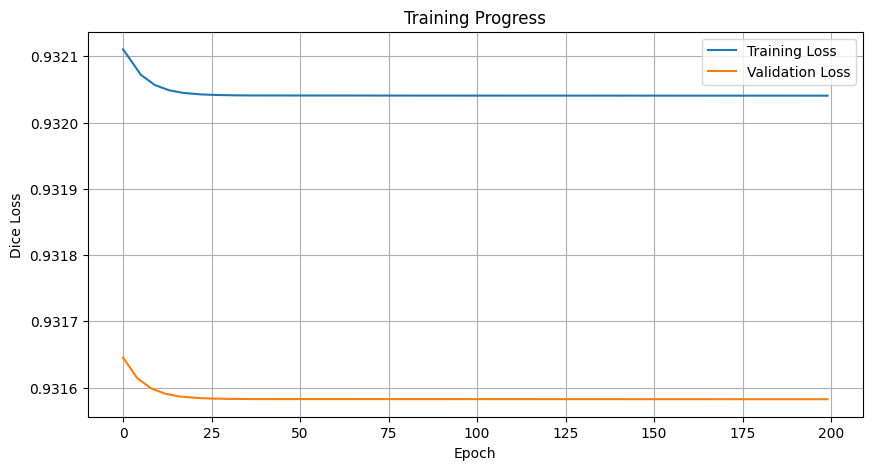

In [31]:
def dice_loss(pred, target, smooth=1e-5):
    """Dice loss for segmentation tasks"""
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

class LaneDataset(torch.utils.data.Dataset):
    """Dataset wrapper for lane detection"""
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.float32) / 255.0
        mask = self.masks[idx].astype(np.float32)

        # Convert to CHW format
        img = np.transpose(img, (2, 0, 1))
        return torch.tensor(img), torch.tensor(mask).unsqueeze(0)

# Prepare data loaders
train_dataset = LaneDataset(train_images, train_masks)
test_dataset = LaneDataset(test_images, test_masks)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

# Training loop
def train_epoch():
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            outputs = model(images)
            loss = dice_loss(outputs, masks)
            total_loss += loss.item()
    return total_loss / len(test_loader)

# Training process
print("Starting training...")
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss = train_epoch()
    val_loss = validate()
    epoch_time = time.time() - start_time

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "lane_net_best.pth")

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Time: {epoch_time:.2f}s")

# Load best model
model.load_state_dict(torch.load("lane_net_best.pth"))
model.eval()

# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.grid()
plt.show()

In [35]:
class LaneProcessor:
    """Real-time lane processing with hysteresis-based departure detection"""
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.warning_active = False
        self.consecutive_safe = 0
        self.image_width = IMG_WIDTH
        self.hysteresis_buffer = deque(maxlen=HYSTERESIS_FRAMES)

    def process_segmentation(self, seg_map):
        """Convert segmentation map to lane polynomials"""
        # Binarize and process
        binary = (seg_map > 0.5).astype(np.uint8) * 255
        histogram = np.sum(binary[binary.shape[0]//2:, :], axis=0)

        # Find lane bases
        midpoint = histogram.shape[0] // 2
        # Handle cases where no lane pixels are detected
        if np.sum(histogram[:midpoint]) == 0:
            leftx_base = -1 # Indicate no left lane found
        else:
            leftx_base = np.argmax(histogram[:midpoint])

        if np.sum(histogram[midpoint:]) == 0:
            rightx_base = -1 # Indicate no right lane found
        else:
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint


        # Sliding window parameters
        nwindows = 9
        margin = 50
        minpix = 50
        window_height = binary.shape[0] // nwindows

        # Identify non-zero pixels
        nonzero = binary.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Lists to store indices
        left_lane_inds = []
        right_lane_inds = []

        # Perform sliding windows
        for window in range(nwindows):
            win_y_low = binary.shape[0] - (window+1)*window_height
            win_y_high = binary.shape[0] - window*window_height
            win_xleft_low = max(0, leftx_current - margin)
            win_xleft_high = min(binary.shape[1], leftx_current + margin)
            win_xright_low = max(0, rightx_current - margin)
            win_xright_high = min(binary.shape[1], rightx_current + margin)

            # Identify lane pixels
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                             (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                              (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Update current positions
            if len(good_left_inds) > minpix:
                leftx_current = np.int32(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int32(np.mean(nonzerox[good_right_inds]))

            # Append indices
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

        # Concatenate indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Fit polynomials
        if len(left_lane_inds) > 100 and len(right_lane_inds) > 100:
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]

            self.left_fit = np.polyfit(lefty, leftx, 2)
            self.right_fit = np.polyfit(righty, rightx, 2)
        else:
            self.left_fit = None
            self.right_fit = None


        return self.left_fit, self.right_fit

    def detect_departure(self, left_fit, right_fit):
        """Detect lane departure with hysteresis"""
        normalized_offset = 0.0 # Default offset if no lanes are detected
        if left_fit is None or right_fit is None:
            # If no lanes are detected, the warning state remains unchanged
            return self.warning_active, normalized_offset

        # Calculate road center at bottom of image
        y_eval = IMG_HEIGHT - 1
        left_lane_pos = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        right_lane_pos = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]

        road_center = (left_lane_pos + right_lane_pos) / 2
        car_center = self.image_width / 2
        offset = car_center - road_center

        # Calculate normalized offset (0-1)
        normalized_offset = abs(offset) / (self.image_width / 2)

        # Hysteresis logic
        if normalized_offset > WARNING_THRESHOLD:
            self.warning_active = True
            self.consecutive_safe = 0
        elif normalized_offset < RESET_THRESHOLD:
            self.consecutive_safe += 1
            if self.consecutive_safe >= HYSTERESIS_FRAMES:
                self.warning_active = False
        else:
            pass

        return self.warning_active, normalized_offset

# Test lane processor
processor = LaneProcessor()
test_mask = train_masks[0]
left_fit, right_fit = processor.process_segmentation(test_mask)
warning, offset = processor.detect_departure(left_fit, right_fit)

print(f"Lane processing test: Warning={warning}, Offset={offset:.2f}")

Lane processing test: Warning=False, Offset=0.08


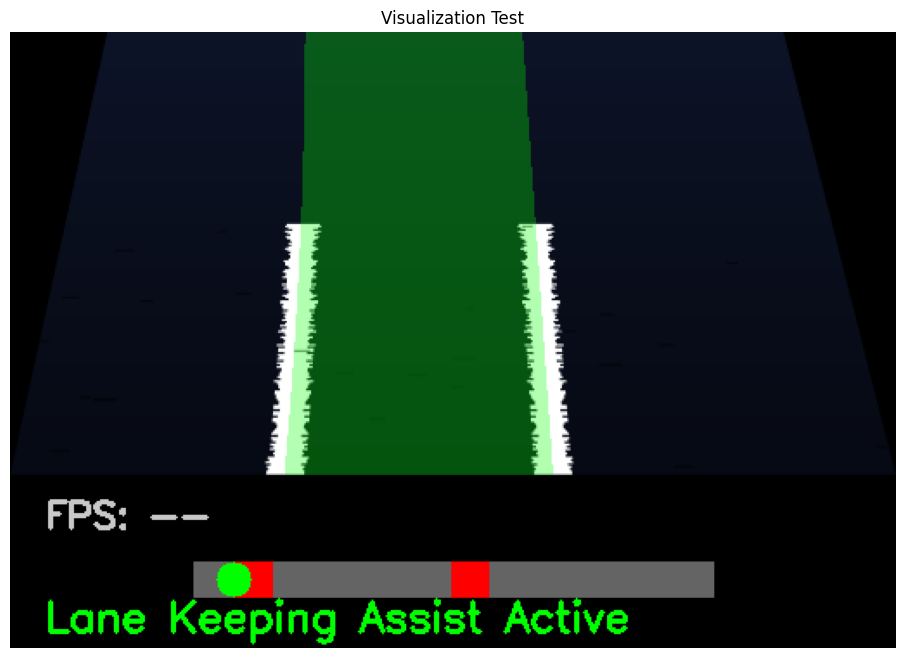

In [33]:
def visualize_lane_detection(frame, seg_map, left_fit, right_fit, warning, offset):
    """Create production-quality visualization with metrics"""
    # Create lane overlay
    overlay = frame.copy()
    ploty = np.linspace(0, IMG_HEIGHT-1, IMG_HEIGHT)

    if left_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])

    if right_fit is not None:
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

    # Draw lane area
    if left_fit is not None and right_fit is not None:
        pts = np.hstack((pts_left, pts_right))
        color = (0, 0, 255) if warning else (0, 255, 0)
        cv2.fillPoly(overlay, np.int32([pts]), color)

    # Blend overlay
    result = cv2.addWeighted(frame, 0.7, overlay, 0.3, 0)

    # Add metrics panel
    metrics_panel = np.zeros((100, IMG_WIDTH, 3), dtype=np.uint8)

    # FPS counter (will be updated in runtime)
    cv2.putText(metrics_panel, "FPS: --", (20, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200, 200, 200), 2)

    # Departure meter
    meter_width = 300
    meter_x = (IMG_WIDTH - meter_width) // 2
    cv2.rectangle(metrics_panel, (meter_x, 50), (meter_x + meter_width, 70), (100, 100, 100), -1)

    # Warning zone
    warning_x1 = meter_x + int(meter_width * RESET_THRESHOLD)
    warning_x2 = meter_x + int(meter_width * WARNING_THRESHOLD)
    cv2.rectangle(metrics_panel, (warning_x1, 50), (warning_x2, 70), (0, 0, 255), -1)
    cv2.rectangle(metrics_panel, (meter_x + meter_width - warning_x2, 50),
                 (meter_x + meter_width - warning_x1, 70), (0, 0, 255), -1)

    # Current offset indicator
    offset_x = meter_x + int(meter_width * min(offset, 1.0))
    if offset > WARNING_THRESHOLD:
        cv2.circle(metrics_panel, (offset_x, 60), 10, (0, 0, 255), -1)
    else:
        cv2.circle(metrics_panel, (offset_x, 60), 10, (0, 255, 0), -1)

    # Warning status
    status = "LANE DEPARTURE WARNING!" if warning else "Lane Keeping Assist Active"
    color = (0, 0, 255) if warning else (0, 255, 0)
    cv2.putText(metrics_panel, status, (20, 90),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Combine result and metrics
    output = np.vstack((result, metrics_panel))
    return output

# Test visualization
test_frame = train_images[0]
test_mask = train_masks[0]
left_fit, right_fit = processor.process_segmentation(test_mask)
warning, offset = processor.detect_departure(left_fit, right_fit)
output = visualize_lane_detection(test_frame, test_mask, left_fit, right_fit, warning, offset)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Visualization Test")
plt.axis('off')
plt.show()

Processing frame 100/100 | Current FPS: 52.7 | Avg Latency: 13.3 ms
REAL-TIME PERFORMANCE RESULTS (100 frames)
Total processing time: 1.88 seconds
Average FPS: 53.1 (Target: ≥15 FPS)
Average latency: 13.3 ms/frame (Target: ≤66.7 ms)
Max latency: 25.1 ms


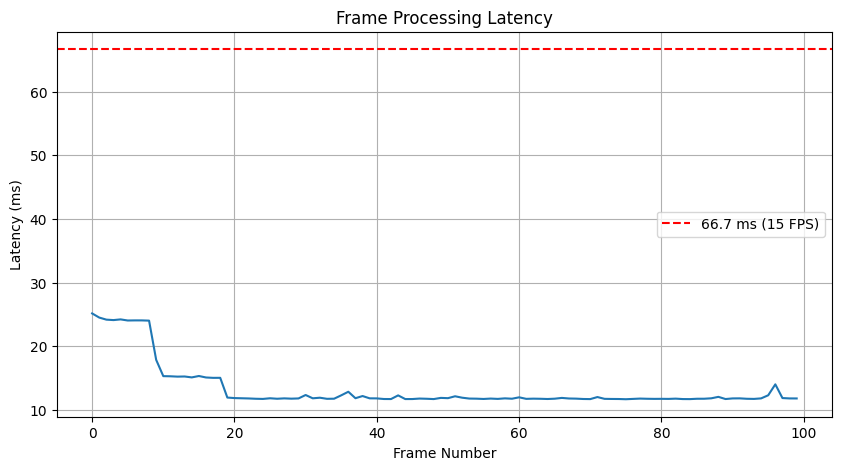

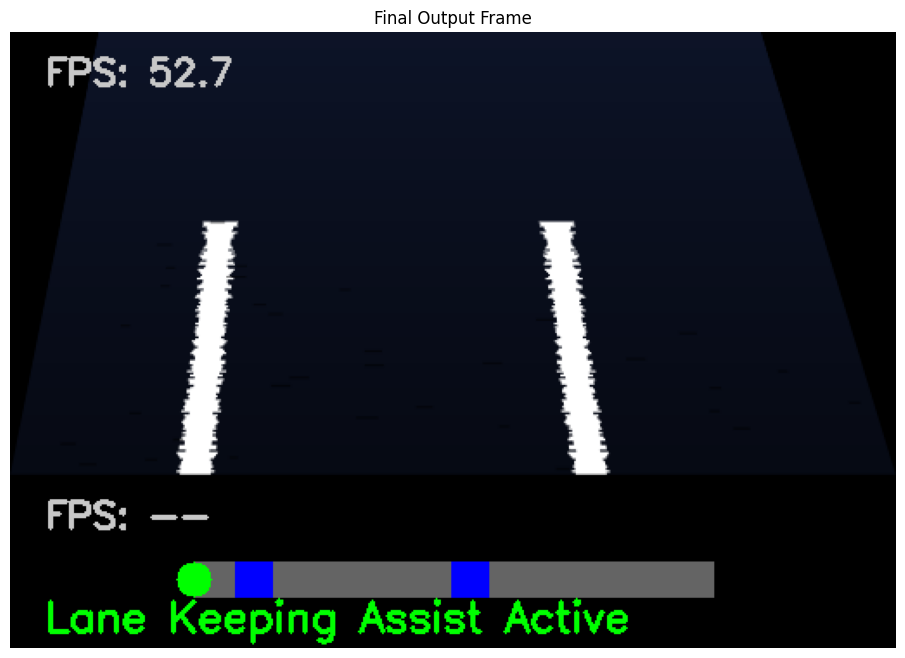

In [36]:
def run_real_time_demo():
    """Run real-time simulation with performance metrics"""
    processor = LaneProcessor()
    frame_count = 0
    start_time = time.time()
    latencies = []

    # Create video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('lane_detection_demo.mp4', fourcc, 20.0, (IMG_WIDTH, IMG_HEIGHT + 100))

    # Process 100 frames
    for i in range(100):
        # Generate test frame
        frame = generate_synthetic_lane_image()
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Preprocessing
        start_frame = time.time()
        frame_resized = cv2.resize(frame_rgb, (IMG_WIDTH, IMG_HEIGHT))
        frame_tensor = torch.tensor(frame_resized).permute(2, 0, 1).float() / 255.0
        frame_tensor = frame_tensor.unsqueeze(0).to(DEVICE)

        # Model inference
        with torch.no_grad():
            seg_map = model(frame_tensor).cpu().numpy()[0, 0]

        # Lane processing
        left_fit, right_fit = processor.process_segmentation(seg_map)
        warning, offset = processor.detect_departure(left_fit, right_fit)

        # Visualization
        output_frame = visualize_lane_detection(
            frame_resized, seg_map, left_fit, right_fit, warning, offset
        )

        # Performance metrics
        frame_time = time.time() - start_frame
        latencies.append(frame_time * 1000)

        # Update FPS counter
        current_fps = frame_count / (time.time() - start_time + 1e-5)
        cv2.putText(output_frame, f"FPS: {current_fps:.1f}", (20, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (200, 200, 200), 2)

        # Save frame
        out.write(cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR))

        # Update counters
        frame_count += 1
        if frame_count % 20 == 0:
            clear_output(wait=True)
            print(f"Processing frame {frame_count}/100 | "
                  f"Current FPS: {current_fps:.1f} | "
                  f"Avg Latency: {np.mean(latencies):.1f} ms")

    # Final metrics
    total_time = time.time() - start_time
    final_fps = frame_count / total_time
    avg_latency = np.mean(latencies)

    # Release resources
    out.release()

    # Print results
    print(f"REAL-TIME PERFORMANCE RESULTS ({frame_count} frames)")
    print(f"Total processing time: {total_time:.2f} seconds")
    print(f"Average FPS: {final_fps:.1f} (Target: ≥15 FPS)")
    print(f"Average latency: {avg_latency:.1f} ms/frame (Target: ≤66.7 ms)")
    print(f"Max latency: {np.max(latencies):.1f} ms")

    # Plot latency distribution
    plt.figure(figsize=(10, 5))
    plt.plot(latencies)
    plt.title('Frame Processing Latency')
    plt.xlabel('Frame Number')
    plt.ylabel('Latency (ms)')
    plt.axhline(y=1000/15, color='r', linestyle='--', label='66.7 ms (15 FPS)')
    plt.legend()
    plt.grid()
    plt.show()

    # Display sample output
    plt.figure(figsize=(12, 8))
    plt.imshow(output_frame)
    plt.title("Final Output Frame")
    plt.axis('off')
    plt.show()

# Run real-time demo
print("Starting real-time performance test...")
run_real_time_demo()

In [37]:
'''
Main notes:
Here "real-time" refers to processing speed, not input source. I'm simulating a real-time loop using synthetic data.
'''

'\nMain notes:\nHere "real-time" refers to processing speed, not input source. I\'m simulating a real-time loop using synthetic data.\n'